Домашнее задание

Построение прогноза временного ряда с использованием изученных методов.
Цель: В этом домашнем задании будет заниматься очень интересными прогнозами, которые вполне могут быть полезны для организации работы метро - попробуем построить модель, которая предсказывает, сколько пассажиров будут им пользоваться в ближайшее время.
Подготовка

1. Скачиваем данные по загруженности метро вот отсюда https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume
2. Проводим базовый EDA, вам понадобятся только 4 столбца датасета - traffic_volume (наша целевая переменная), date_time, holiday (является ли день некоторым праздником) и temp (температура воздуха)
3. По результатам EDA убеждаемся, что в этом временном ряду во-первых, есть дубликаты, а во-вторых, нарушена равномерность временных интервалов, т.е. не все значения отстоят друг от друга на 1 час - дубликаты удаляем, а временные интервалы выравниваем и заполняем пропуски при помощи линейной интерполяции (подсказка - в этом вам помогут функции pd.date_range, и interpolate, пример можно найти здесь - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html) 

Моделирование

Теперь, когда ряд выглядит более-менее адекватно, настало время прогнозировать. Нашей целью будет построить модель, которая способна прогнозировать загрузку метро на ближайшую неделю (т.е, так как данные у нас часовые, модель должна предсказывать на 24*7 точек вперёд). 

1. Отложите последние две недели в датасете для тестирования вашей модели - на этих данных вы будете проверять финальное качество всех моделек
2. Теперь у вас осталось еще много-много наблюдений во временном ряду, исходя из графиков, трендов и т.д., попробуйте предположить, какие исторические данные действительно будут релевантны для прогнозов текущих значений, возможно, предыдущие три года уже не так сильно влияют на следующую неделю и можно часть данных выкинуть
3. Генерируем дополнительные признаки из индекса, особенно нужен день недели и час дня
4. Строим baseline прогноз - по тем данным, которые вы решили оставить для обучения модели, посчитайте средние значения по часам и по дням (вам поможет data.groupby(["weekday", "hour"])["traffic_volume"].mean() и используйте эти значения в качестве прогноза на отложенную выборку - посчитайте метрики качества, которые вы посчитаете нужными
5. А теперь свободное творчество - попробуйте построить разные модели, которые мы с вами разбирали, и побить качество базового прогноза. 

Несколько советов 

- для SARIMA модели имеет смысл указать недельную сезонность (т.е. 24*7), чтобы она учла падения по выходным
- попробуйте использовать температуру воздуха, как признак, в этом случае можно отдельно спрогнозировать температуру (например, используя SARIMA), а затем воспользоваться этими предсказаниями, когда будете делать прогноз для отложенной части выборки

6. Наконец, когда вы подберете модель, устраивающую вас по качеству на отложенной выборке, используйте эту выборку для построения прогноза на следующую неделю и попробуйте построить доверительные интервалы для этого прогноза
7. Теперь вы круто разбираетесь в прогнозировании и временных рядах :)

In [1]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook
from scipy.optimize import minimize
from sklearn.model_selection import TimeSeriesSplit

from datetime import datetime, timedelta

import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')



Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [3]:
loaded_data = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')


In [4]:
loaded_data.head()


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [5]:
data = loaded_data.loc[:, ['traffic_volume', 'date_time', 'holiday', 'temp']] 
data.head()


,traffic_volume,date_time,holiday,temp
0,5545,2012-10-02 09:00:00,None,288.28
1,4516,2012-10-02 10:00:00,None,289.36
2,4767,2012-10-02 11:00:00,None,289.58
3,5026,2012-10-02 12:00:00,None,290.13
4,4918,2012-10-02 13:00:00,None,291.14


In [6]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   traffic_volume  48204 non-null  int64  
 1   date_time       48204 non-null  object 
 2   holiday         48204 non-null  object 
 3   temp            48204 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ MB


In [7]:
# Признак "date_time" является объектом, переведем в формат DateTime:
data['date_time'] = pd.to_datetime(data['date_time'])
data.head()


,traffic_volume,date_time,holiday,temp
0,5545,2012-10-02 09:00:00,None,288.28
1,4516,2012-10-02 10:00:00,None,289.36
2,4767,2012-10-02 11:00:00,None,289.58
3,5026,2012-10-02 12:00:00,None,290.13
4,4918,2012-10-02 13:00:00,None,291.14


# EDA

In [8]:
data.shape


(48204, 4)

In [9]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   traffic_volume  48204 non-null  int64         
 1   date_time       48204 non-null  datetime64[ns]
 2   holiday         48204 non-null  object        
 3   temp            48204 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.5+ MB


In [10]:
# У нас нет пропущенных данных


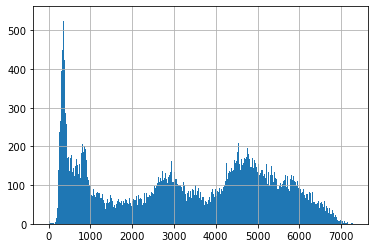

In [11]:
# Посмотрим на распределение целевой переменной:
data['traffic_volume'].hist(bins = 500);


In [12]:
# На графике выделяются несколько пиков.


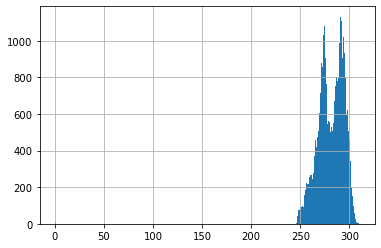

In [13]:
data['temp'].hist(bins = 500);


In [14]:
# Посмотрим на количество праздников
data['holiday'].nunique()


12

In [15]:
# Признак 'holiday' имеет более 2-х уникальных значений, посмотрим каких:
data['holiday'].value_counts()


None                         48143
Labor Day                        7
Thanksgiving Day                 6
Martin Luther King Jr Day        6
Christmas Day                    6
New Years Day                    6
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Columbus Day                     5
State Fair                       5
Independence Day                 5
Name: holiday, dtype: int64

In [16]:
# По количеству значений праздников, можно сделать предположение, что данные покрывают период в 5-6 лет, проверим это:
print(data['date_time'].min(), '/', data['date_time'].max())


2012-10-02 09:00:00 / 2018-09-30 23:00:00


In [17]:
# Наше предположение подтвердилось, данные представленны с октября 2012 по сентябрь 2018 года.


In [18]:
data['date_time'].dt.second.value_counts()


0    48204
Name: date_time, dtype: int64

In [19]:
data['date_time'].dt.minute.value_counts()


0    48204
Name: date_time, dtype: int64

In [20]:
data['date_time'].dt.hour.value_counts()


4     2091
6     2087
8     2080
7     2079
10    2078
5     2063
1     2049
23    2040
0     2037
3     2025
2     2019
9     2018
22    1994
16    1988
18    1986
21    1982
20    1979
14    1969
19    1961
12    1955
11    1952
15    1934
17    1933
13    1905
Name: date_time, dtype: int64

In [21]:
# Время наблюдения кратно часу, т.е. у нас часовые данные


# Подготовка

In [22]:
dfa = data.copy()
print(dfa.shape, data.shape)
print(dfa.head())


(48204, 4) (48204, 4)
   traffic_volume           date_time holiday    temp
0            5545 2012-10-02 09:00:00    None  288.28
1            4516 2012-10-02 10:00:00    None  289.36
2            4767 2012-10-02 11:00:00    None  289.58
3            5026 2012-10-02 12:00:00    None  290.13
4            4918 2012-10-02 13:00:00    None  291.14


In [23]:
# Отсортируем данные по дате:
dfa.sort_values(by = ['date_time'], inplace = True)
dfa.head()


,traffic_volume,date_time,holiday,temp
0,5545,2012-10-02 09:00:00,None,288.28
1,4516,2012-10-02 10:00:00,None,289.36
2,4767,2012-10-02 11:00:00,None,289.58
3,5026,2012-10-02 12:00:00,None,290.13
4,4918,2012-10-02 13:00:00,None,291.14


In [24]:
# Удалим дубли данных, если таковые есть:
dfa.drop_duplicates(subset = ['date_time'], inplace = True, ignore_index = True)
dfa.shape


(40575, 4)

In [25]:
# Проверим временной интервал на равномерность.
# Для этого посмотрим на разность между соседними датами, она должна быть равна 1 часу (3600 секунд).

delta_hourse = []

for i in range(dfa.shape[0] - 1):
    delta = dfa['date_time'][i+1] - dfa['date_time'][i]
    delta_hourse.append(delta.total_seconds())
    
len(delta_hourse)


40574

In [26]:
set(delta_hourse)


{3600.0,
 7200.0,
 10800.0,
 14400.0,
 18000.0,
 21600.0,
 25200.0,
 28800.0,
 32400.0,
 36000.0,
 39600.0,
 43200.0,
 46800.0,
 50400.0,
 54000.0,
 61200.0,
 64800.0,
 75600.0,
 79200.0,
 86400.0,
 90000.0,
 108000.0,
 118800.0,
 122400.0,
 169200.0,
 234000.0,
 334800.0,
 421200.0,
 424800.0,
 874800.0,
 26593200.0}

In [27]:
# Но, как мы видим, у нас много отличных от 1 часа (3600 секунд) значений, т. е. есть пропуски по датам.


In [28]:
# Сделаем признак date_time id:
dfa.set_index('date_time', inplace = True)
dfa.iloc[104:106, :]


,traffic_volume,holiday,temp
date_time,,,
2012-10-07 00:00:00,1233,None,276.11
2012-10-07 03:00:00,323,None,275.73


In [29]:
dfa = dfa.asfreq(freq = 'H')
dfa.shape


(52551, 3)

In [30]:
dfa.iloc[111:115, :]


,traffic_volume,holiday,temp
date_time,,,
2012-10-07 00:00:00,1233.0,None,276.11
2012-10-07 01:00:00,NaN,NaN,NaN
2012-10-07 02:00:00,NaN,NaN,NaN
2012-10-07 03:00:00,323.0,None,275.73


In [31]:
# Теперь заполним пропуски в созданных данных:
dfa['traffic_volume'] = dfa['traffic_volume'].interpolate()
dfa['temp'] = dfa['temp'].interpolate()
dfa['holiday'].replace(np.nan, 'None', inplace=True)
dfa.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Freq: H
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   traffic_volume  52551 non-null  float64
 1   holiday         52551 non-null  object 
 2   temp            52551 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.6+ MB


In [32]:
dfa.iloc[111:115, :]


,traffic_volume,holiday,temp
date_time,,,
2012-10-07 00:00:00,1233.000000,None,276.110000
2012-10-07 01:00:00,929.666667,None,275.983333
2012-10-07 02:00:00,626.333333,None,275.856667
2012-10-07 03:00:00,323.000000,None,275.730000


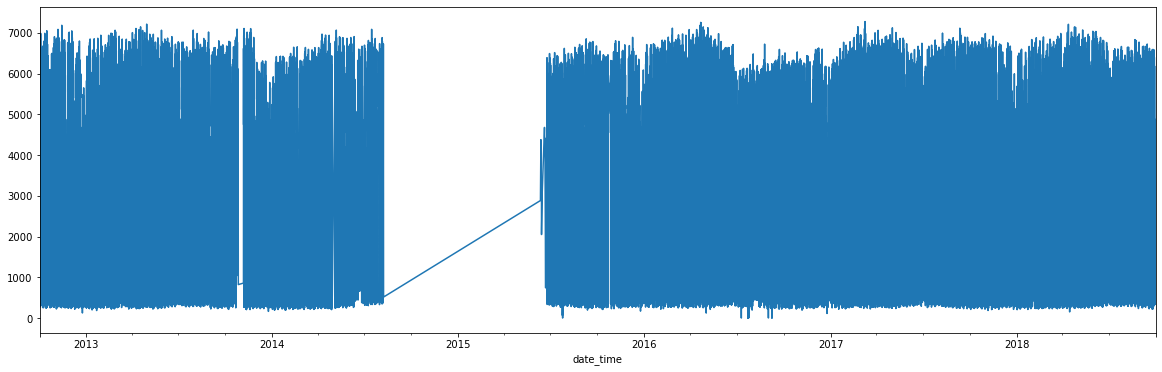

In [33]:
dfa['traffic_volume'].plot(figsize=(20,6));


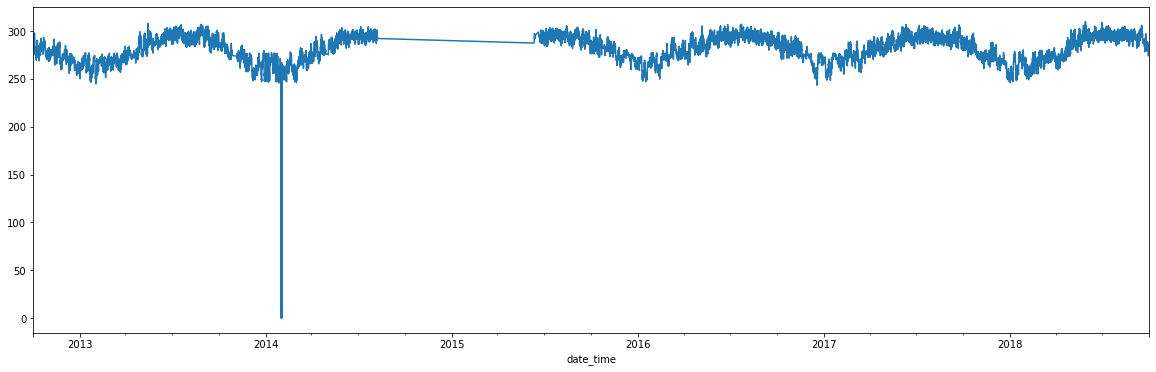

In [34]:
dfa['temp'].plot(figsize=(20,6));


In [121]:
# На графиках в данных в период 2015-2016 видим большой пробел в данных, 
# Для дальнейшей работы не будем использовать данные ранее середины 2015 год, т.е. остается, примерно, 3 последних года.


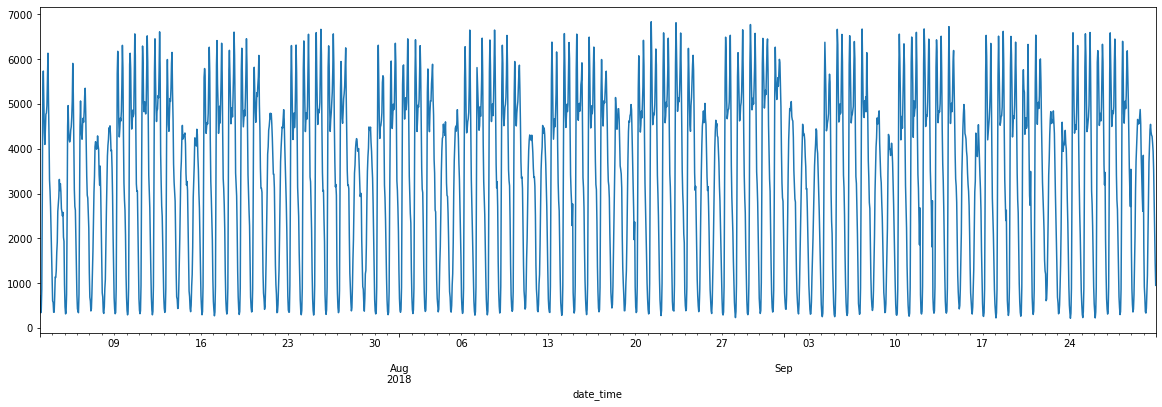

In [36]:
# посмотрим на крайние 3 месяца:
dfa['traffic_volume'][-3*30*24:].plot(figsize = (20,6));


In [37]:
# Выглядит отлично: четко выделяются рабочие дни (бОльший трафик) и выходные/праздничные дни.


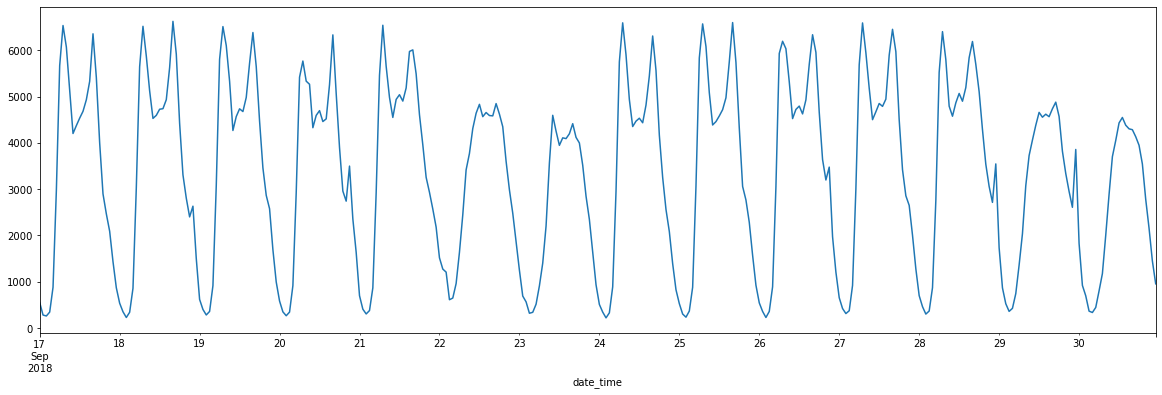

In [38]:
dfa['traffic_volume'][-2*7*24:].plot(figsize = (20,6));


In [39]:
# Применим к нашим данным сглаживание:


In [40]:
def plotMovingAverage(series, window, center = True, plot_intervals = False, scale=1.96, plot_anomalies = False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        center - whether to center the window
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window, center=center).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:].fillna(0), rolling_mean[window:].fillna(0))
        deviation = np.std(series[window:] - rolling_mean[window:])
        upper_bond = rolling_mean + (mae + scale * deviation)
        lower_bond = rolling_mean - (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            series = pd.DataFrame(series)
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    

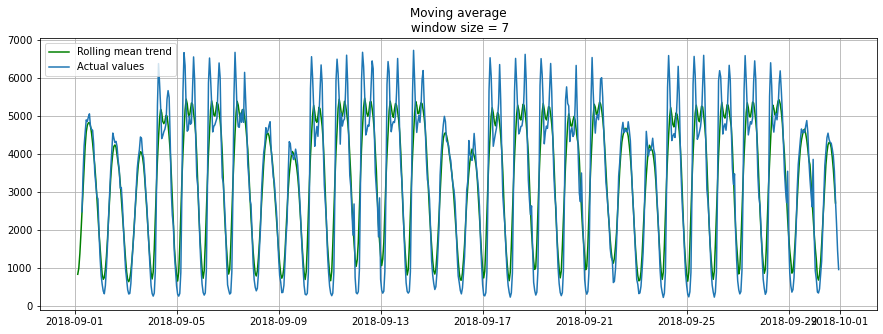

In [41]:
plotMovingAverage(dfa['traffic_volume'][-30*24:], 7) 


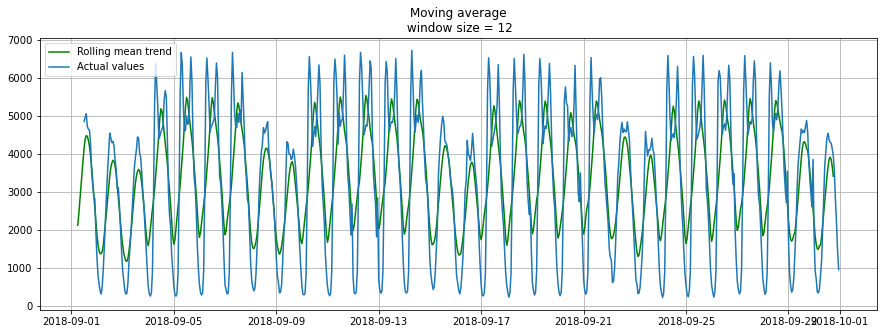

In [42]:
plotMovingAverage(dfa['traffic_volume'][-30*24:], 12) 


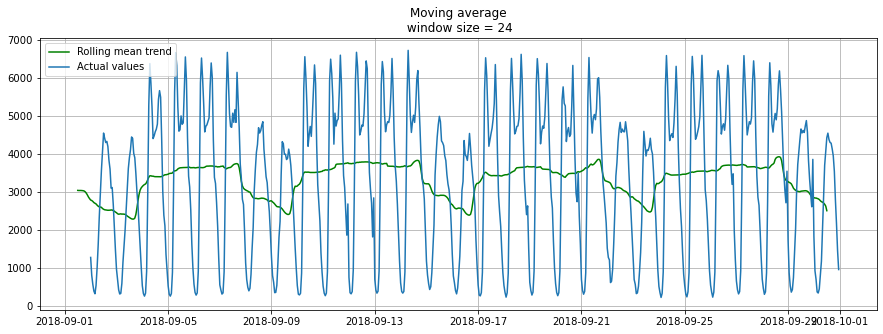

In [43]:
plotMovingAverage(dfa['traffic_volume'][-30*24:], 24) 


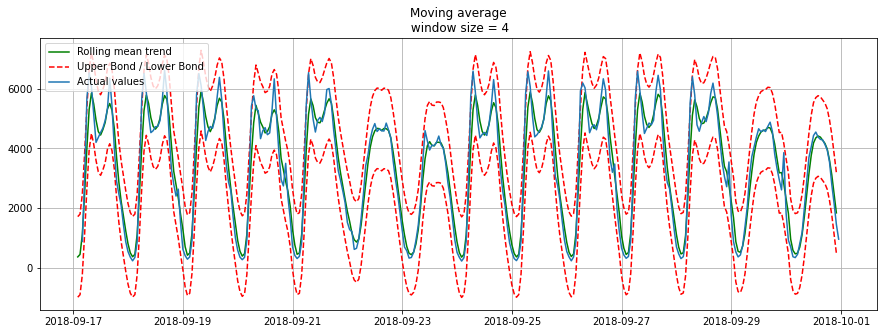

In [124]:
plotMovingAverage(dfa['traffic_volume'][-2*7*24:], 4, plot_intervals = True, plot_anomalies = True)


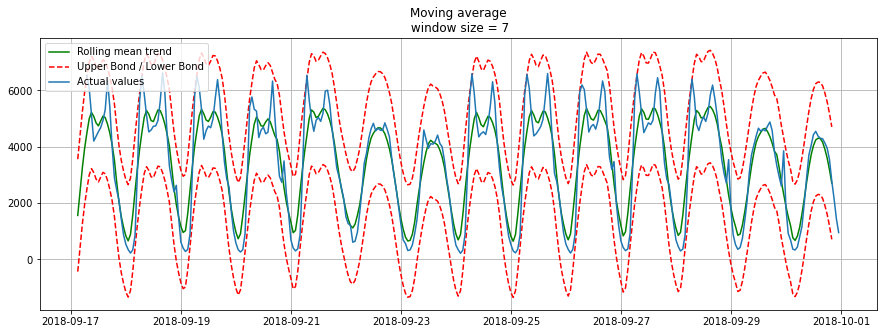

In [123]:
plotMovingAverage(dfa['traffic_volume'][-2*7*24:], 7, plot_intervals = True, plot_anomalies = True)


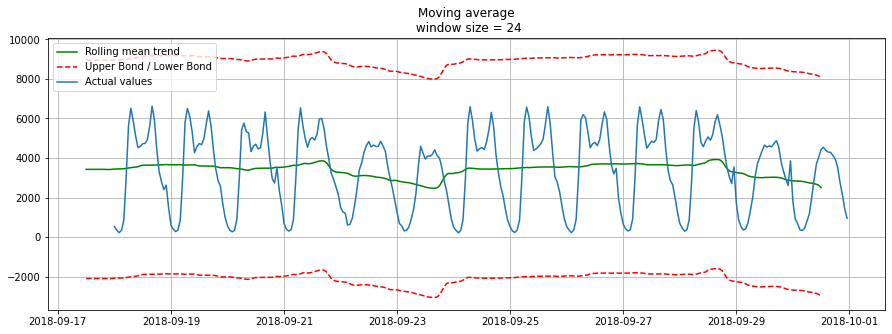

In [122]:
plotMovingAverage(dfa['traffic_volume'][-2*7*24:], 24, plot_intervals = True, plot_anomalies = True)


# Моделирование


In [49]:
# Отделим последнюю неделю для итоговой оценки наших моделей:
df = dfa[:-7*24]
data_test = dfa[-7*24:]['traffic_volume']
print(df.shape, data_test.shape)


(52383, 3) (168,)


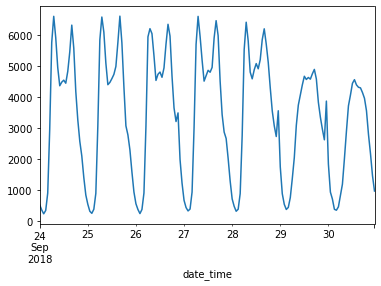

In [50]:
data_test.plot();


In [51]:
# Отделим некоторые временные интервалы:
df_2M = df[- 60 * 24:]
df_1Y = df[- 365 * 24:]
df_3Y = df[- 3 * 365 * 24:]
df_2W = df[- 14 * 24:]


## Base-line


In [52]:
def get_base_line(data):
    data['hour'] = data.index.hour
    data['weekday'] = data.index.weekday
    data_train = data[:-2*7*24]
    data_test = data[-2*7*24:]
    data_base_predict = data_train.groupby(["weekday", "hour"])["traffic_volume"].mean().values
    data_predict = np.concatenate((data_base_predict, data_base_predict))
    error_base_line = mean_absolute_percentage_error(data_test["traffic_volume"], data_predict)
    return error_base_line
    

In [53]:
# Для начала возьмем 3 последних года:
error_base_line = get_base_line(df_3Y)
error_base_line


9.140704947105515

In [54]:
# Попробуем взять данные лишь за 2 последних месяца:
error_base_line_2m = get_base_line(df_2M)
error_base_line_2m


7.9951343046357914

In [55]:
# Попробуем взять данные лишь за последний год:
error_base_line_1Y = get_base_line(df_1Y)
error_base_line_1Y


7.6715498462722325

In [56]:
# Имеем лучший результат 7,67%, для годовых данных, их и будем использовать для итогового прогноза:
df_1Y_d = df_1Y.copy()
df_1Y_d['hour'] = df_1Y_d.index.hour
df_1Y_d['weekday'] = df_1Y_d.index.weekday
data_predict = df_1Y_d.groupby(["weekday", "hour"])["traffic_volume"].mean().values
error_base_line = mean_absolute_percentage_error(data_test, data_predict)
error_base_line


7.3566656222608104

In [57]:
# Запишем данный результат и будем пытаться его улучшить:
df_result = pd.DataFrame(error_base_line, index = ['base_line_1Y'], columns = ['error'])
df_result


,error
base_line_1Y,7.356666


## SARIMA

In [73]:
# Из-за низкой производительности моей машины, для SARIMA я взял для обучения лишь 2 последних недели


In [62]:
def tsplot(y, lags = None, figsize = (12, 7), style = 'bmh'):
   
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method="ols")
        plt.tight_layout()
        

Критерий Дики-Фуллера: p=0.000001


<Figure size 1080x720 with 0 Axes>

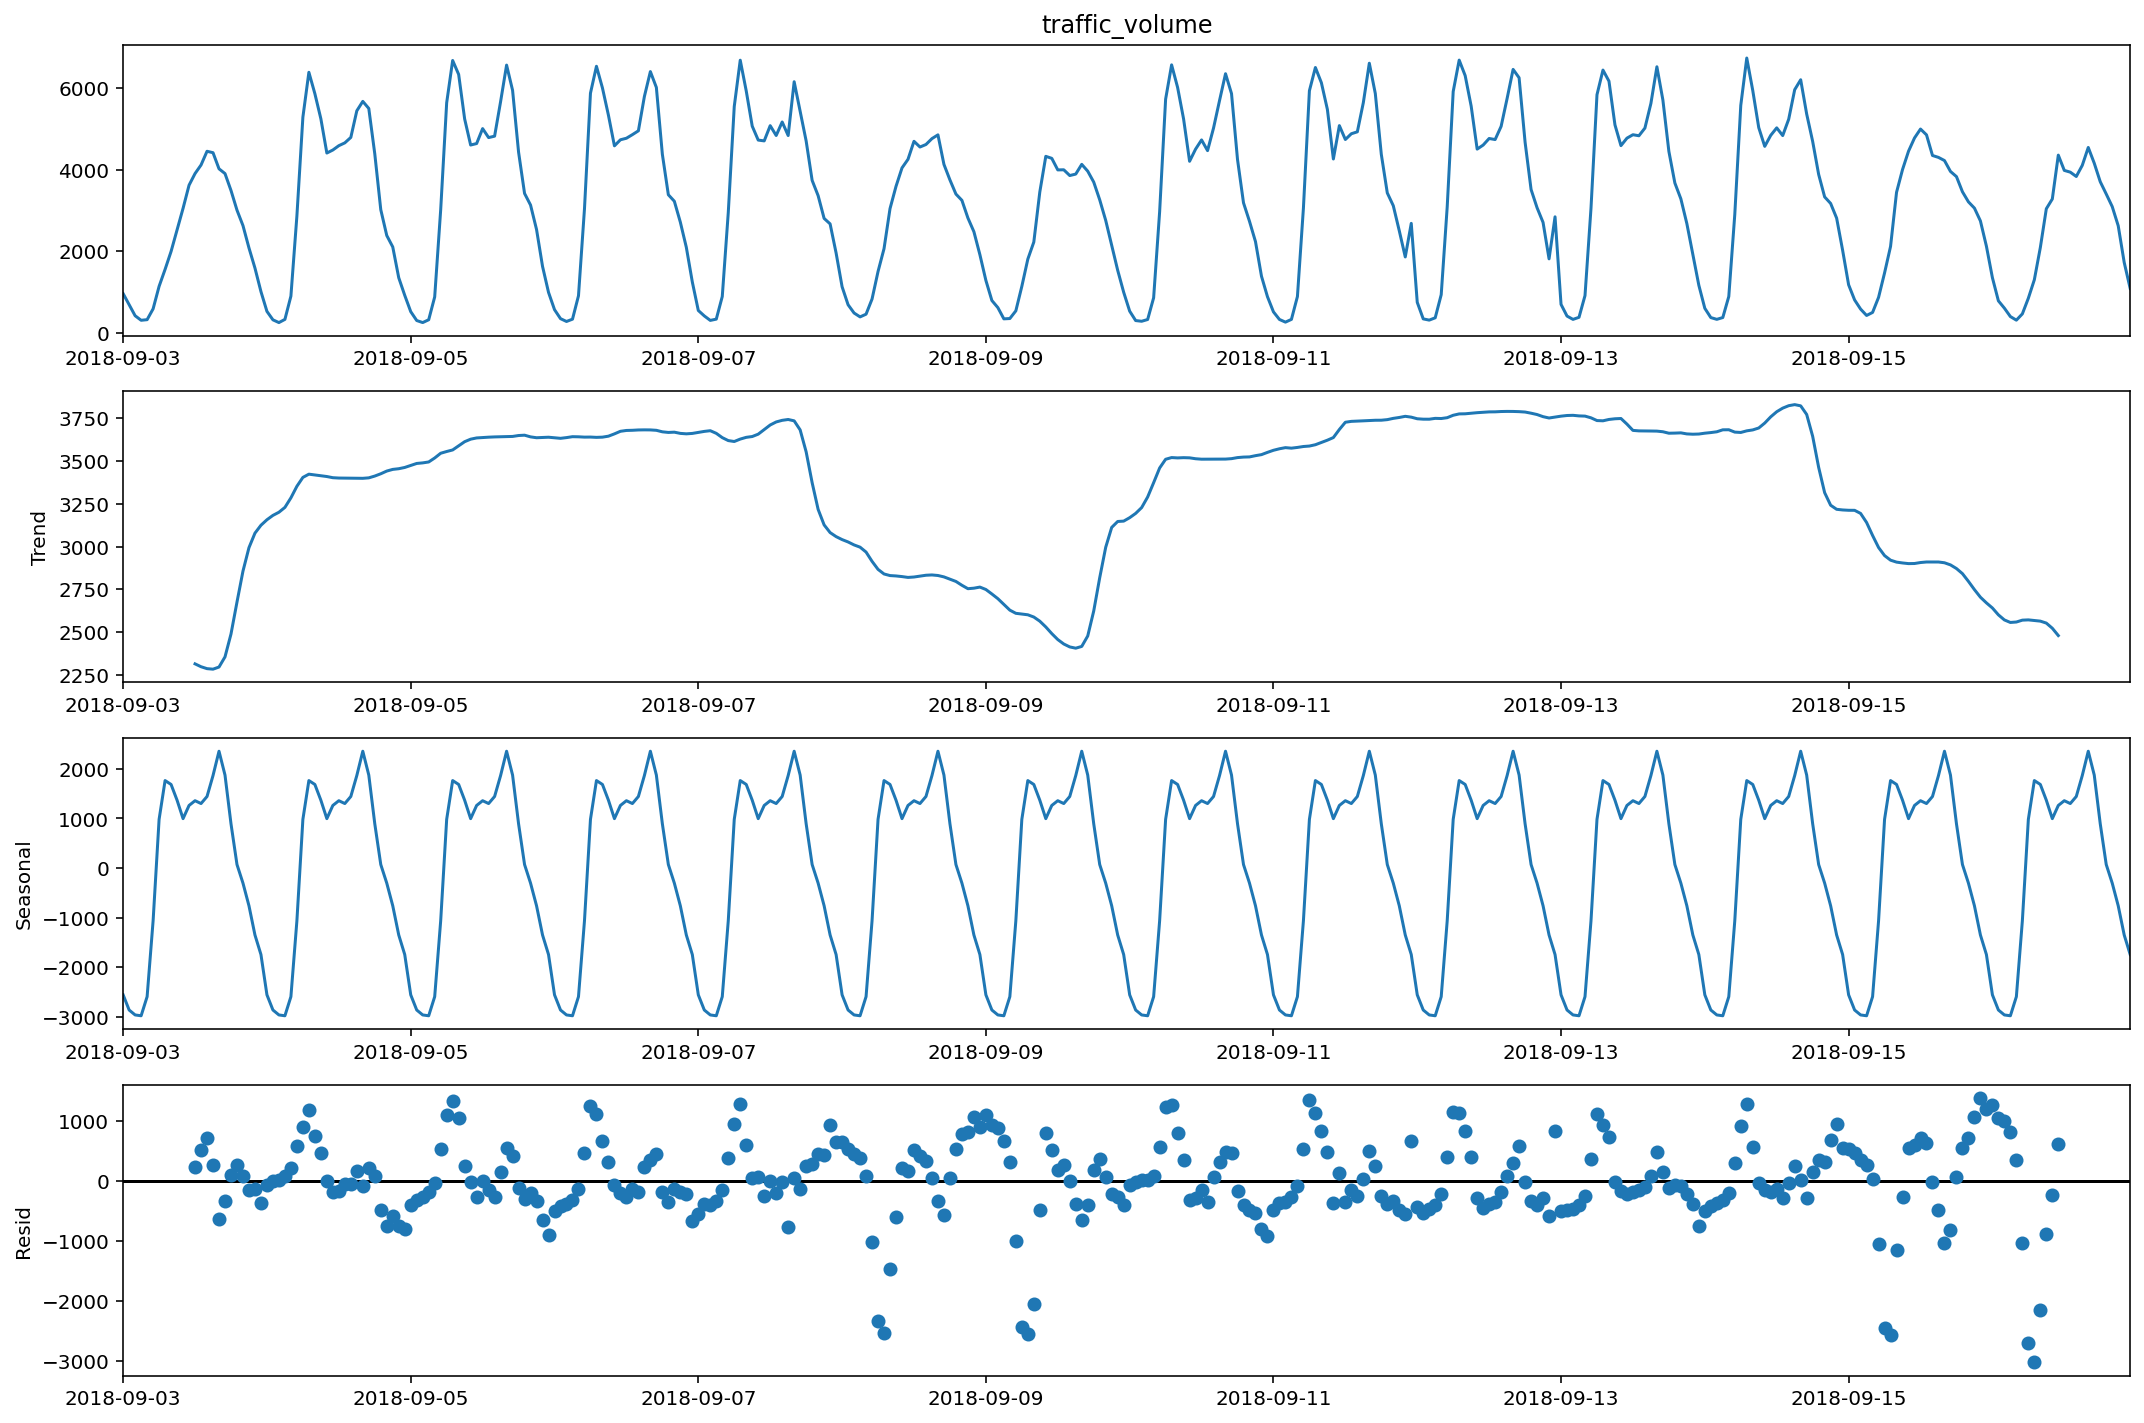

In [57]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df_2W["traffic_volume"]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df_2W["traffic_volume"])[1])


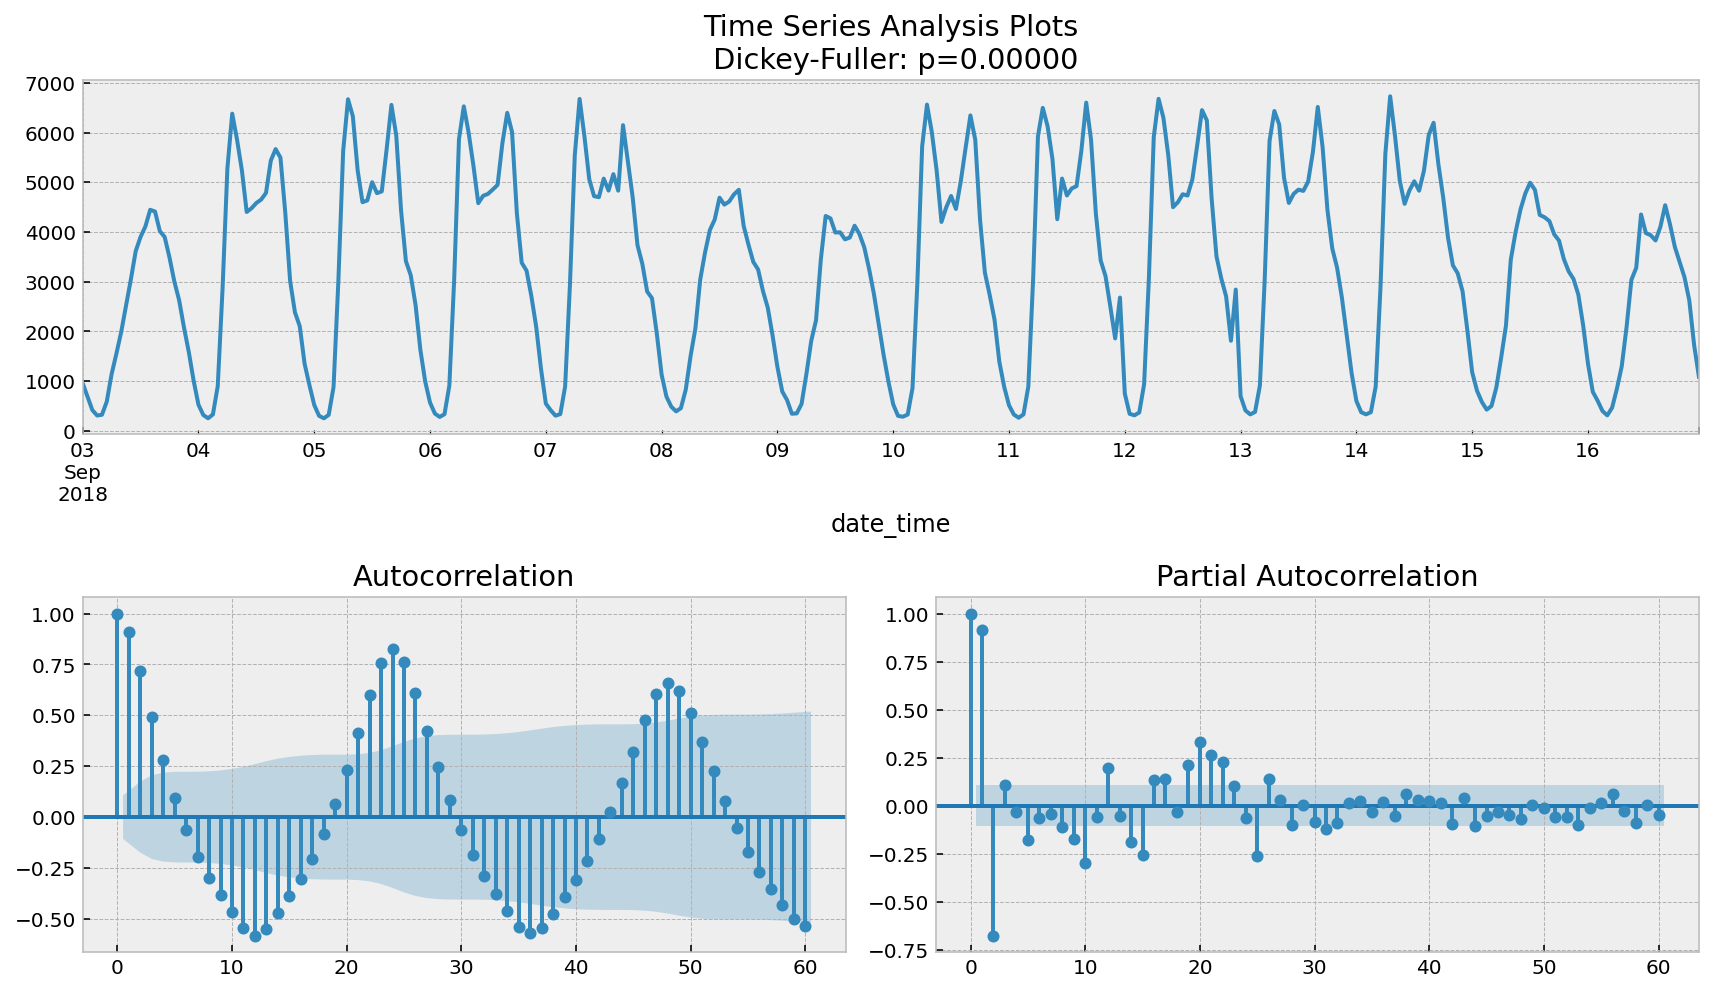

In [58]:
tsplot(df_2W['traffic_volume'], lags = 60)


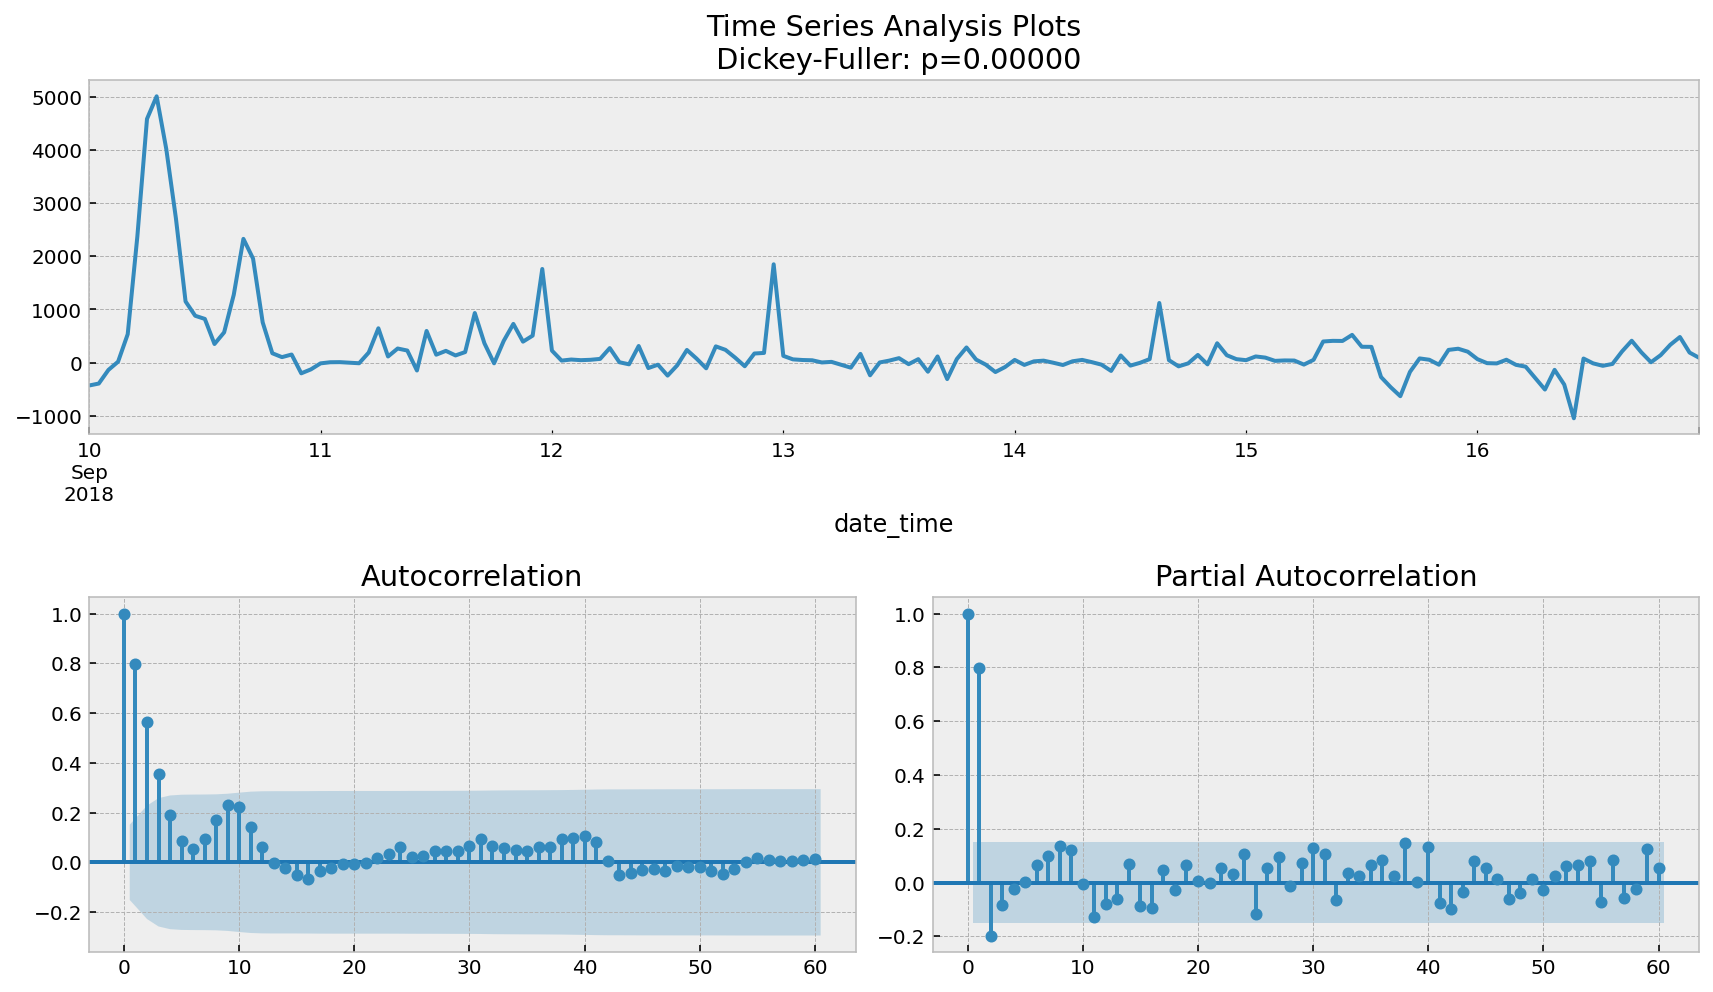

In [59]:
df_2W_dif = df_2W['traffic_volume'] - df_2W['traffic_volume'].shift(24*7)
tsplot(df_2W_dif[24*7:], lags = 60)


In [61]:
# Начальные значения параметров:

# p = 2
# P = 0

# Q = 0
# q = 3

# D = 1
# d = 0

# s = 24*7


In [59]:
ps = range(0, 3)
d = 1 
qs = range(0, 4)
P = 0
D = 1
Q = 0
s = 24*7 

# creating list with all the possible combinations of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)


12

In [71]:
def optimizeSARIMA(data, parameters_list, d, D, s, P, Q):

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        
        try:
            model = sm.tsa.statespace.SARIMAX(data, order = (param[0], d, param[1]), 
                                              seasonal_order = (P, D, Q, s)).fit(disp = -1)
        except:
            continue
        
        aic = model.aic
        
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
  
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by = 'aic', ascending = True).reset_index(drop = True)
    
    return result_table


In [72]:
result_table = optimizeSARIMA(df_2W['traffic_volume'], parameters_list, d, D, s, P, Q)
result_table.head()


  0%|          | 0/12 [00:00<?, ?it/s]

,parameters,aic
0,"(2, 2)",2518.740876
1,"(2, 1)",2520.470416
2,"(2, 3)",2522.175030
3,"(1, 2)",2523.381436
4,"(1, 3)",2523.865817


In [60]:
%%time

p, q = 2, 2 

best_model = sm.tsa.statespace.SARIMAX(df_2W['traffic_volume'], 
                                       order = (p, d, q), seasonal_order = (P, D, Q, s)).fit(disp = -1)
print(best_model.summary())


                                      SARIMAX Results                                       
Dep. Variable:                       traffic_volume   No. Observations:                  336
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 168)   Log Likelihood               -1195.602
Date:                              Fri, 12 Feb 2021   AIC                           2401.205
Time:                                      19:20:38   BIC                           2416.794
Sample:                                  09-10-2018   HQIC                          2407.532
                                       - 09-23-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3441      2.252      0.153      0.879      -4.070       4.759
ar.L2          0.04

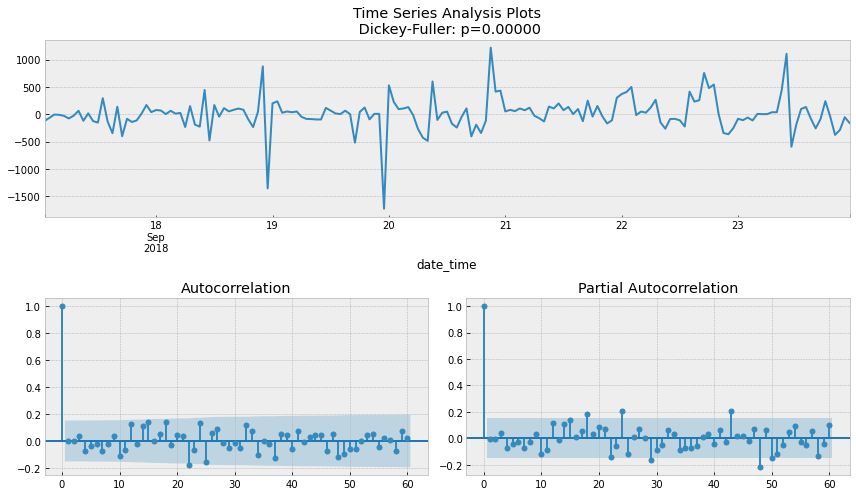

In [63]:
tsplot(best_model.resid[24*7+1:], lags = 60)


In [64]:
# Построим прогноз и посмотрим ошибку:
forecast = best_model.get_forecast(steps = 7*24)
error_sarima = mean_absolute_percentage_error(data_test, forecast.predicted_mean.values)
error_sarima


11.356898993735804

In [65]:
# Результат оказался значительно хуже, чем base line. Сложно их сравнивать, т.к. они обучались на разных интервалов.
# Но в рамках данной задачи в образовательных целях делаю допущение об их сравнении.

In [66]:
df_result.loc['SARIMA'] = [error_sarima]
df_result


,error
base_line_1Y,7.356666
SARIMA,11.356899


## Метод Holt-Winters

In [67]:
class HoltWinters:
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])
            

In [68]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(params, series, loss_function = mean_squared_error):
    errors = []
    values = series.values
    alpha, beta, gamma = params
    tscv = TimeSeriesSplit(n_splits = 3)
    
    for train, test in tscv.split(values):
        model_HW = HoltWinters(series = values[train], slen = 24*7, 
                               alpha = alpha, beta = beta, gamma = gamma, n_preds = 7*24)
        model_HW.triple_exponential_smoothing()
        predictions = model_HW.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))


In [69]:
%%time

x = [0, 0, 0]

opt = minimize(timeseriesCVscore, x0 = x,
               args=(df_1Y['traffic_volume'], mean_squared_error),
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x

model_HW = HoltWinters(df_1Y['traffic_volume'], slen = 24*7,
                       alpha = alpha_final,
                       beta = beta_final,
                       gamma = gamma_final,
                       n_preds = 24*7, scaling_factor = 3)
model_HW.triple_exponential_smoothing()


CPU times: user 56.7 s, sys: 171 ms, total: 56.9 s
Wall time: 57 s


In [70]:
error_HW = mean_absolute_percentage_error(data_test, model_HW.result[-7*24:])
error_HW


8.300924618093394

In [71]:
df_result.loc['HoltWinters'] = [error_HW]
df_result


,error
base_line_1Y,7.356666
SARIMA,11.356899
HoltWinters,8.300925


## ML

In [240]:
ml_data = df_1Y.copy()
ml_data.head()


,traffic_volume,holiday,temp,hour,weekday
date_time,,,,,
2017-09-24 00:00:00,1361.0,None,295.74,0,6
2017-09-24 01:00:00,873.0,None,294.99,1,6
2017-09-24 02:00:00,649.0,None,294.65,2,6
2017-09-24 03:00:00,412.0,None,293.91,3,6
2017-09-24 04:00:00,362.0,None,294.07,4,6


In [241]:
ml_data.index = pd.to_datetime(ml_data.index)
ml_data["hour"] = ml_data.index.hour
ml_data["weekday"] = ml_data.index.weekday
ml_data["month"] = ml_data.index.month
ml_data['is_weekend'] = ml_data['weekday'].isin([5,6])*1
ml_data['no_holiday'] = ml_data['holiday'].isin(['None'])*1
ml_data.drop(['holiday'], axis = 1, inplace = True)

def code_mean(cat_feature, real_feature, data = ml_data):
    return dict(data.groupby(cat_feature)[real_feature].mean())

ml_data['weekday_average'] = list(map(code_mean('weekday', "traffic_volume").get, ml_data['weekday']))
ml_data["hour_average"] = list(map(code_mean('hour', "traffic_volume").get, ml_data['hour']))
ml_data["month_average"] = list(map(code_mean('month', "traffic_volume").get, ml_data['month']))
ml_data


,traffic_volume,temp,hour,weekday,month,is_weekend,no_holiday,weekday_average,hour_average,month_average
date_time,,,,,,,,,,
2017-09-24 00:00:00,1361.0,295.74,0,6,9,1,1,2468.583726,833.128767,3329.010417
2017-09-24 01:00:00,873.0,294.99,1,6,9,1,1,2468.583726,504.542466,3329.010417
2017-09-24 02:00:00,649.0,294.65,2,6,9,1,1,2468.583726,383.450294,3329.010417
2017-09-24 03:00:00,412.0,293.91,3,6,9,1,1,2468.583726,377.030724,3329.010417
2017-09-24 04:00:00,362.0,294.07,4,6,9,1,1,2468.583726,730.009785,3329.010417
...,...,...,...,...,...,...,...,...,...,...
2018-09-23 19:00:00,3516.0,295.23,19,6,9,1,1,2468.583726,3348.852055,3329.010417
2018-09-23 20:00:00,2846.0,292.94,20,6,9,1,1,2468.583726,2914.336986,3329.010417
2018-09-23 21:00:00,2346.0,292.27,21,6,9,1,1,2468.583726,2715.120548,3329.010417


In [242]:
ml_data['weekday_hour_average'] = [(i, j, k) for i, j, k in zip(ml_data.index.weekday, ml_data.index.hour, ml_data.index.month)]

avr_list = ml_data.groupby(["weekday", "hour", 'month'])["traffic_volume"].mean()
mape_avr = {}
for i in range(len(avr_list)):
    inda = avr_list.index[i]
    mape_avr[inda] = avr_list[inda]
    
ml_data['weekday_hour_average'] = ml_data['weekday_hour_average'].map(mape_avr)
ml_data


,traffic_volume,temp,hour,weekday,month,is_weekend,no_holiday,weekday_average,hour_average,month_average,weekday_hour_average
date_time,,,,,,,,,,,
2017-09-24 00:00:00,1361.0,295.74,0,6,9,1,1,2468.583726,833.128767,3329.010417,1304.4
2017-09-24 01:00:00,873.0,294.99,1,6,9,1,1,2468.583726,504.542466,3329.010417,788.8
2017-09-24 02:00:00,649.0,294.65,2,6,9,1,1,2468.583726,383.450294,3329.010417,601.2
2017-09-24 03:00:00,412.0,293.91,3,6,9,1,1,2468.583726,377.030724,3329.010417,372.6
2017-09-24 04:00:00,362.0,294.07,4,6,9,1,1,2468.583726,730.009785,3329.010417,336.6
...,...,...,...,...,...,...,...,...,...,...,...
2018-09-23 19:00:00,3516.0,295.23,19,6,9,1,1,2468.583726,3348.852055,3329.010417,3436.4
2018-09-23 20:00:00,2846.0,292.94,20,6,9,1,1,2468.583726,2914.336986,3329.010417,2998.0
2018-09-23 21:00:00,2346.0,292.27,21,6,9,1,1,2468.583726,2715.120548,3329.010417,2406.2


In [243]:
ml_data = pd.get_dummies(ml_data, columns = ['hour', 'weekday', 'month'])
ml_data.head()


,traffic_volume,temp,is_weekend,no_holiday,weekday_average,hour_average,month_average,weekday_hour_average,hour_0,hour_1,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date_time,,,,,,,,,,,,,,,,,,,,,
2017-09-24 00:00:00,1361.0,295.74,1,1,2468.583726,833.128767,3329.010417,1304.4,1,0,...,0,0,0,0,0,0,1,0,0,0
2017-09-24 01:00:00,873.0,294.99,1,1,2468.583726,504.542466,3329.010417,788.8,0,1,...,0,0,0,0,0,0,1,0,0,0
2017-09-24 02:00:00,649.0,294.65,1,1,2468.583726,383.450294,3329.010417,601.2,0,0,...,0,0,0,0,0,0,1,0,0,0
2017-09-24 03:00:00,412.0,293.91,1,1,2468.583726,377.030724,3329.010417,372.6,0,0,...,0,0,0,0,0,0,1,0,0,0
2017-09-24 04:00:00,362.0,294.07,1,1,2468.583726,730.009785,3329.010417,336.6,0,0,...,0,0,0,0,0,0,1,0,0,0


In [244]:
def timeseries_train_test_split(X, y, test_size):

    test_index = int(len(X)*(1 - test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test


In [246]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 5)

def plotModelResults(model, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=False, plot_anomalies=False):

    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(y_test, prediction)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
    
def plotCoefficients(model):
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
      

In [328]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

scaler = MinMaxScaler()

y = ml_data['traffic_volume']
X = ml_data.drop(['traffic_volume'], axis = 1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size = 0.1)

X_train_scaled_all = scaler.fit_transform(X_train)
X_test_scaled_all = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X = X_train_scaled_all, y = y_train)


LinearRegression()

16.774223625216262


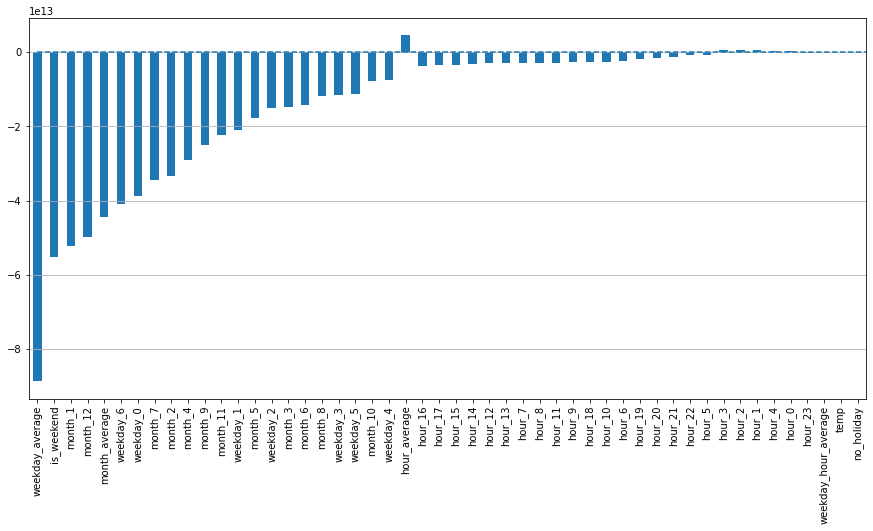

In [330]:
y_predict = lr.predict(X_test_scaled_all)
print(mean_absolute_percentage_error(y_test, y_predict))

plotCoefficients(lr)


In [347]:
# Какая-то странная картина влияния признаков, почти все признаки дают отрицательное влияние.

16.65040007835827


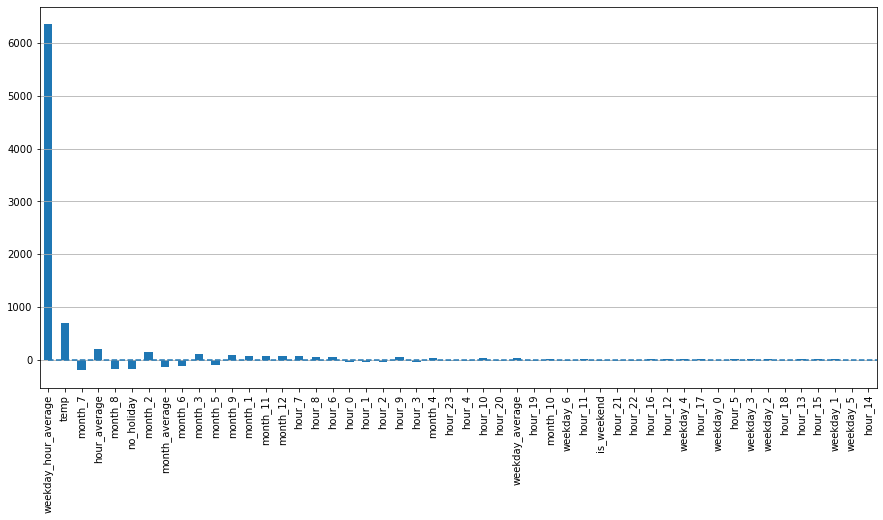

In [334]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv = tscv, alphas = np.linspace(5, 10))
ridge.fit(X_train_scaled_all, y_train)

y_predict = ridge.predict(X_test_scaled_all)
print(mean_absolute_percentage_error(y_test, y_predict))

plotCoefficients(ridge)


In [346]:
# Из важных признаков отметил: среднее по месяц, день недели, час; температура; и не праздничный ли день.


9.154122847998433


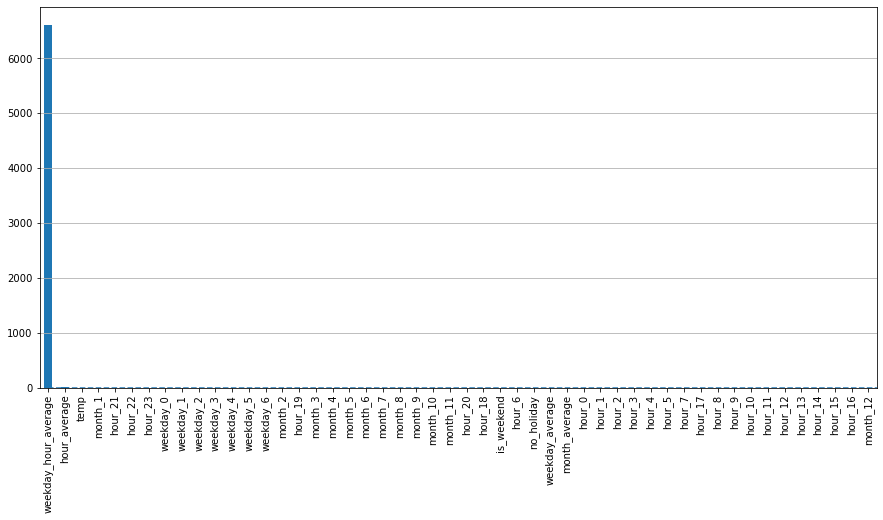

In [335]:
lasso = LassoCV(cv = tscv, eps = 0.001)
lasso.fit(X_train_scaled_all, y_train)

y_predict = lasso.predict(X_test_scaled_all)
print(mean_absolute_percentage_error(y_test, y_predict))

plotCoefficients(lasso)


In [227]:
# Единственный ненулевой признак - это среднее по месяцу, времени, часу. 


In [282]:
y_1 = ml_data['traffic_volume']
X_1 = ml_data[['weekday_hour_average']]

X_train, X_test, y_train, y_test = timeseries_train_test_split(X_1, y_1, test_size = 0.1)

scaler_1 = MinMaxScaler()

X_train_scaled = scaler_1.fit_transform(X_train)
X_test_scaled = scaler_1.transform(X_test)

lasso_1 = LassoCV(cv = tscv, eps = 0.01)
lasso_1.fit(X_train_scaled, y_train)

y_predict_1 = lasso_1.predict(X_test_scaled)

print(mean_absolute_percentage_error(y_test, y_predict_1))


8.142377117849325


In [262]:
# Хороший результат. И посмотрим что получится без этого признака:


In [323]:
y_2 = ml_data['traffic_volume']
X_2 = ml_data.drop(['traffic_volume', 'weekday_hour_average'], axis = 1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X_2, y_2, test_size = 0.1)

scaler_2 = MinMaxScaler()

X_train_scaled = scaler_2.fit_transform(X_train)
X_test_scaled = scaler_2.transform(X_test)

lasso_2 = LassoCV(cv = tscv, eps = 0.001)
lasso_2.fit(X_train_scaled, y_train)

y_predict_2 = lasso_2.predict(X_test_scaled)
print(mean_absolute_percentage_error(y_test, y_predict_2))


37.38463044761297


In [336]:
y_3 = ml_data['traffic_volume']
X_3 = ml_data[['weekday_hour_average', 'temp', 'no_holiday']]

X_train, X_test, y_train, y_test = timeseries_train_test_split(X_3, y_3, test_size = 0.1)

scaler_1 = MinMaxScaler()

X_train_scaled = scaler_1.fit_transform(X_train)
X_test_scaled = scaler_1.transform(X_test)

lasso_1 = LassoCV(cv = tscv, eps = 0.01)
lasso_1.fit(X_train_scaled, y_train)

y_predict_1 = lasso_1.predict(X_test_scaled)

print(mean_absolute_percentage_error(y_test, y_predict_1))


9.190910485745334


### Прогноз праздничных дней:


In [283]:
# Создадим список праздничных дат:
from pandas.tseries.offsets import BDay
from pandas.tseries.holiday import USFederalHolidayCalendar 
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar = USFederalHolidayCalendar())

# Создадим функуцию на проверку праздничного дня (праздничный день отмечается как 0):
def no_holiday(data):
    data.index[0].date()
    holidays_list = []
    for i in data.index:
        if i.date in us_bd.holidays:
            holidays_list.append(1)
        else:
            holidays_list.append(0)
    return holidays_list


### Прогноз температуры


In [284]:
temp_df = df_1Y.copy()
temp_df_train = temp_df[:-2*7*24]
temp_df_test = temp_df[-2*7*24:]


In [285]:
temp_df_train.index = pd.to_datetime(temp_df_train.index)
temp_df_train["hour"] = temp_df_train.index.hour
temp_df_train["weekday"] = temp_df_train.index.weekday
temp_df_train["month"] = temp_df_train.index.month

df_temp_predict = temp_df_train.groupby(["weekday", "hour"])["temp"].mean().values
temp_predict = np.concatenate((df_temp_predict, df_temp_predict))
error_temp = mean_absolute_percentage_error(temp_df_test["temp"], temp_predict)
error_temp


4.17008948441594

In [286]:
# Отлично, будем использовать данную модель для прогноза погоды


In [287]:
len(df_temp_predict)


168

### Подготовим данные


In [288]:
df_test = pd.DataFrame(data_test)
df_test.index = pd.to_datetime(df_test.index)
df_test["hour"] = df_test.index.hour
df_test["weekday"] = df_test.index.weekday
df_test["month"] = df_test.index.month
df_test['is_weekend'] = df_test['weekday'].isin([5,6])*1
df_test['no_holiday'] = no_holiday(df_test)
df_test['temp'] = df_temp_predict

def code_mean(cat_feature, real_feature = 'traffic_volume', data = df_test):
    return dict(data.groupby(cat_feature)[real_feature].mean())

df_test['weekday_average'] = list(map(code_mean('weekday').get, df_test['weekday']))
df_test["hour_average"] = list(map(code_mean('hour').get, df_test['hour']))
df_test["month_average"] = list(map(code_mean('month').get, df_test['month']))

df_test['weekday_hour_average'] = [(i, j, k) for i, j, k in zip(df_test.index.weekday, df_test.index.hour, df_test.index.month)]
avr_list = df_test.groupby(["weekday", "hour", 'month'])["traffic_volume"].mean()
mape_avr = {}
for i in range(len(avr_list)):
    inda = avr_list.index[i]
    mape_avr[inda] = avr_list[inda]
    
df_test['weekday_hour_average'] = df_test['weekday_hour_average'].map(mape_avr)

df_test.drop(['traffic_volume'], axis = 1, inplace = True)


In [289]:
df_test = pd.get_dummies(df_test, columns = ['hour', 'weekday', 'month'])
df_test.head()


,is_weekend,no_holiday,temp,weekday_average,hour_average,month_average,weekday_hour_average,hour_0,hour_1,hour_2,...,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_9
date_time,,,,,,,,,,,,,,,,,,,,,
2018-09-24 00:00:00,0,0,280.01914,3442.0,927.285714,3387.928571,509.0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
2018-09-24 01:00:00,0,0,279.49954,3442.0,524.714286,3387.928571,344.0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
2018-09-24 02:00:00,0,0,278.98180,3442.0,359.000000,3387.928571,219.0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2018-09-24 03:00:00,0,0,278.59854,3442.0,359.285714,3387.928571,328.0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2018-09-24 04:00:00,0,0,278.26494,3442.0,743.857143,3387.928571,888.0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [290]:
# Добавим недостающие признаки с нулевыми значениями:
for i in X.columns:
    if i not in df_test.columns:
        df_test[i] = 0
df_test


,is_weekend,no_holiday,temp,weekday_average,hour_average,month_average,weekday_hour_average,hour_0,hour_1,hour_2,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_10,month_11,month_12
date_time,,,,,,,,,,,,,,,,,,,,,
2018-09-24 00:00:00,0,0,280.019140,3442.000000,927.285714,3387.928571,509.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-09-24 01:00:00,0,0,279.499540,3442.000000,524.714286,3387.928571,344.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2018-09-24 02:00:00,0,0,278.981800,3442.000000,359.000000,3387.928571,219.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2018-09-24 03:00:00,0,0,278.598540,3442.000000,359.285714,3387.928571,328.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-09-24 04:00:00,0,0,278.264940,3442.000000,743.857143,3387.928571,888.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,1,0,283.876667,2504.291667,3573.714286,3387.928571,3543.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-09-30 20:00:00,1,0,283.090980,2504.291667,3004.857143,3387.928571,2781.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-09-30 21:00:00,1,0,282.050137,2504.291667,2665.285714,3387.928571,2159.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [319]:
# Возьмем по одному признаку
X_train = ml_data[['weekday_hour_average']]
X_test = df_test[['weekday_hour_average']]
y_train = ml_data['traffic_volume']
y_test = data_test

scaler_1 = MinMaxScaler()

X_train_scaled = scaler_1.fit_transform(X_train)
X_test_scaled = scaler_1.transform(X_test)

lasso_1 = LassoCV(cv = tscv, eps = 0.01)
lasso_1.fit(X_train_scaled, y_train)

y_predict_1 = lasso_1.predict(X_test_scaled)

lasso_error = mean_absolute_percentage_error(y_test, y_predict_1)

print(lasso_error)


1.7594424522558008


In [299]:
df_result.loc['LinearRegression'] = [lasso_error]
df_result


,error
base_line_1Y,7.356666
SARIMA,11.356899
HoltWinters,8.300925
LinearRegression,1.813439
Boosting,11.303293


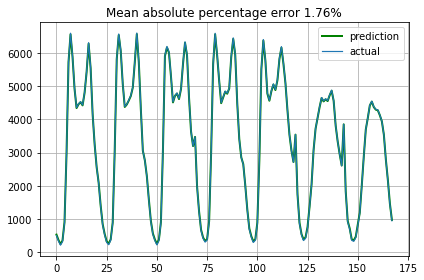

In [320]:
plt.plot(lasso_1.predict(X_test_scaled), "g", label="prediction", linewidth=2.0)
plt.plot(y_test.values, label="actual", linewidth = 1.2)

plt.title("Mean absolute percentage error {0:.2f}%".format(lasso_error))
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True);


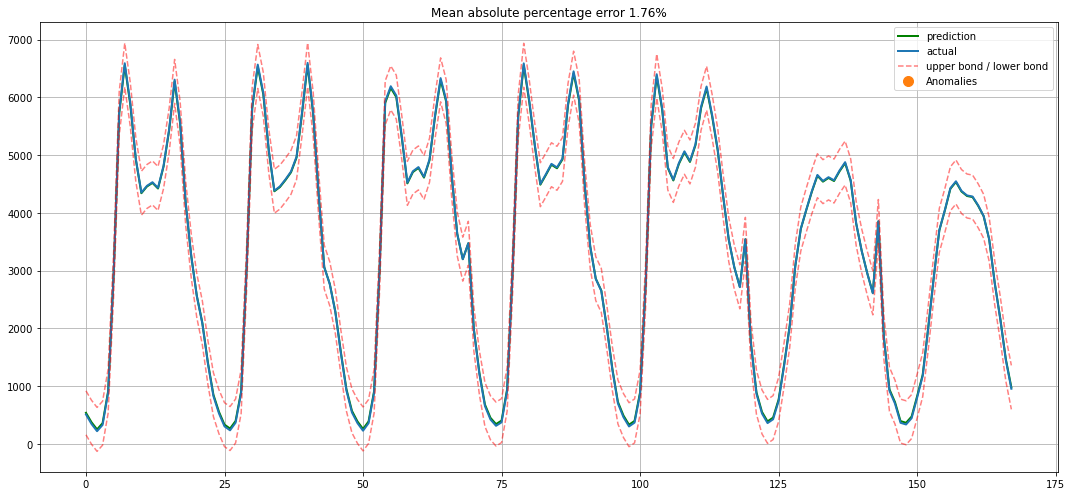

In [321]:
plotModelResults(lasso_1, 
                 X_train = X_train_scaled, 
                 X_test = X_test_scaled, 
                 plot_intervals = True, plot_anomalies = True)


In [ ]:
# Просто фантастика. Прогноз практически совпадает с фактическими данными. Да и интервалы очень узкие. 
# Красиво, что не верится и похоже на переобучение.


In [341]:
# Возьмем по 3 признакам
X_train = ml_data[['weekday_hour_average', 'temp', 'no_holiday']]
X_test = df_test[['weekday_hour_average', 'temp', 'no_holiday']]
y_train = ml_data['traffic_volume']
y_test = data_test

scaler_3 = MinMaxScaler()

X_train_scaled = scaler_3.fit_transform(X_train)
X_test_scaled = scaler_3.transform(X_test)

lasso_3 = LassoCV(cv = tscv, eps = 0.01)
lasso_3.fit(X_train_scaled, y_train)

y_predict_3 = lasso_3.predict(X_test_scaled)

lasso_error_3 = mean_absolute_percentage_error(y_test, y_predict_3)

print(lasso_error_3)


4.258076408983534


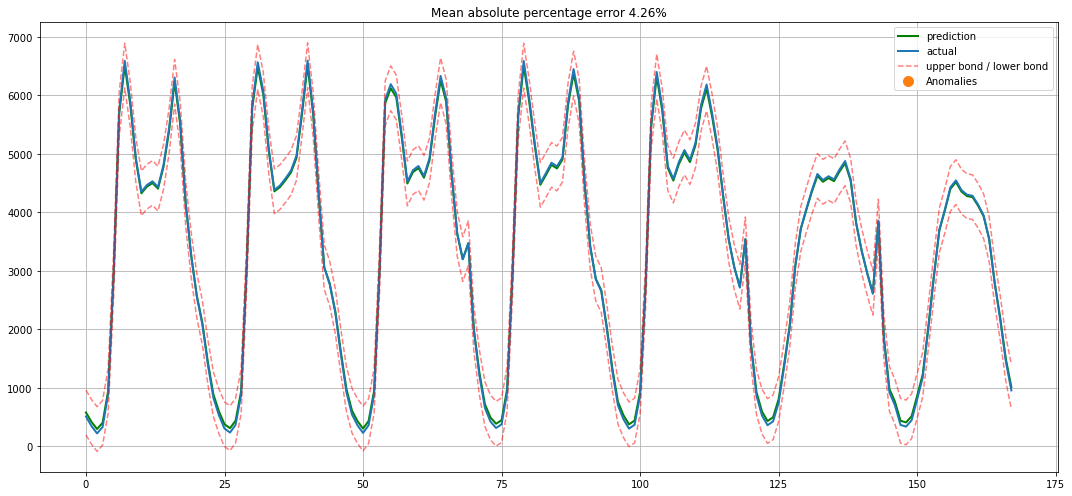

In [342]:
plotModelResults(lasso_3, 
                 X_train = X_train_scaled, 
                 X_test = X_test_scaled, 
                 plot_intervals = True, plot_anomalies = True)


In [345]:
# Ошибка увеличилась, но интервалы остались такими же как и при одном признаке.


In [343]:
df_result.loc['lasso_error_3'] = [lasso_error_3]
df_result


,error
base_line_1Y,7.356666
SARIMA,11.356899
HoltWinters,8.300925
LinearRegression,1.813439
Boosting,12.035101
lasso_error_3,4.258076


## Boosting

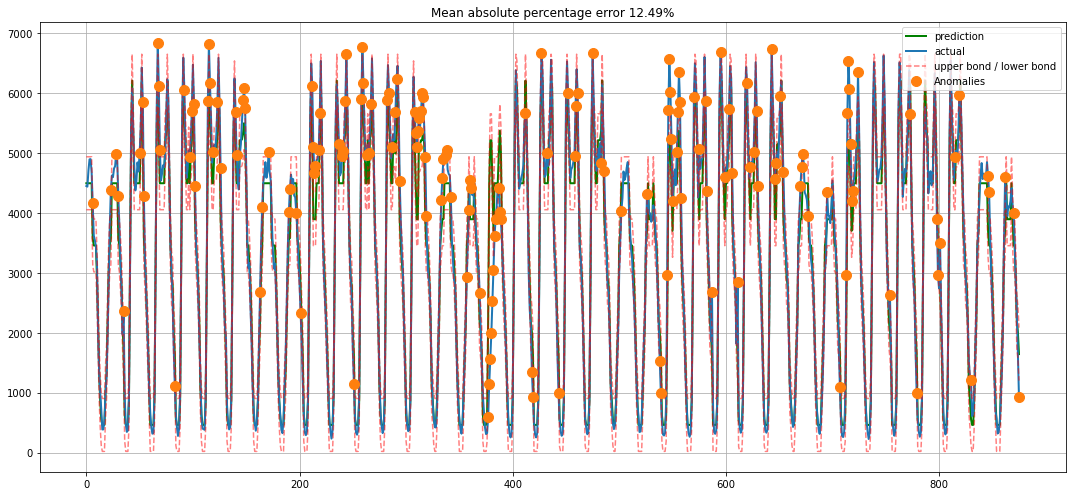

In [304]:
from sklearn.ensemble import AdaBoostRegressor

gbr = AdaBoostRegressor(n_estimators = 10)
gbr.fit(X_train_scaled_all, y_train)

plotModelResults(gbr, 
                 X_train = X_train_scaled_all, 
                 X_test = X_test_scaled_all, 
                 plot_intervals = True, plot_anomalies = True)


In [305]:
df_test_sc = scaler.fit_transform(df_test)
error_adb = mean_absolute_percentage_error(data_test, gbr.predict(df_test_sc))
error_adb


12.035100628517677

In [306]:
df_result.loc['Boosting'] = [error_adb]
df_result


,error
base_line_1Y,7.356666
SARIMA,11.356899
HoltWinters,8.300925
LinearRegression,1.813439
Boosting,12.035101


## Facebook Prophet - automating routines


In [155]:
from fbprophet import Prophet


In [156]:
# number of future predictions
predictions = 2*7*24

# creating a specific format dataset 
df_fb = dfa['traffic_volume'][-12*30*24:].reset_index()
df_fb.columns = ['ds', 'y']
df_fb


,ds,y
0,2017-10-06 00:00:00,666.0
1,2017-10-06 01:00:00,374.0
2,2017-10-06 02:00:00,286.0
3,2017-10-06 03:00:00,353.0
4,2017-10-06 04:00:00,833.0
...,...,...
8635,2018-09-30 19:00:00,3543.0
8636,2018-09-30 20:00:00,2781.0
8637,2018-09-30 21:00:00,2159.0
8638,2018-09-30 22:00:00,1450.0


In [157]:
train_df_fb = df_fb[:-predictions]
train_df_fb


,ds,y
0,2017-10-06 00:00:00,666.0
1,2017-10-06 01:00:00,374.0
2,2017-10-06 02:00:00,286.0
3,2017-10-06 03:00:00,353.0
4,2017-10-06 04:00:00,833.0
...,...,...
8299,2018-09-16 19:00:00,3400.0
8300,2018-09-16 20:00:00,3092.0
8301,2018-09-16 21:00:00,2623.0
8302,2018-09-16 22:00:00,1725.0


In [158]:
model_fb = Prophet(weekly_seasonality = True, yearly_seasonality = False, daily_seasonality = True)


In [159]:
# model_fb.fit(train_df_fb)
# на этапе обучения у меня стало выбивать kernel и все полностью сбрасывается.
# хотя были удачные запуски.


In [160]:
# future = model_fb.make_future_dataframe(periods = predictions, freq='H')
# future.tail()


In [161]:
# forecast = model_fb.predict(future)
# forecast.tail()


In [162]:
# error = mean_absolute_percentage_error(df_fb[-predictions:]['y'], forecast[-predictions:]['yhat'])
# print("Mean absolute percentage error {0:.2f}%".format(error))
# _ = model_fb.plot(forecast)


In [163]:
# _ = model_fb.plot_components(forecast)


# Лучшая модель

In [344]:
df_result


,error
base_line_1Y,7.356666
SARIMA,11.356899
HoltWinters,8.300925
LinearRegression,1.813439
Boosting,12.035101
lasso_error_3,4.258076


Лучшая модель для наших данных оказалась регрессия на одном признаке. Этот признак - среднее по месяцу, дню недели и часу.

Так же хорошо себя показала регрессия построенная на 3-х признаках: среднее по месяцу, дню и часу; температура и празничный ли день.

# Выводы

1. Не удалось в полной мере задействовать SARIMA модель из-за низкой мощности моего компьютера. В нее явно надо было запихивать данные за больший интервал времени для обучения.
2. В полной мере прочувствовал и минус SARIMA, ее ресурсозатратность.
3. Для серьезных прогнозов лучшая модель может и не годится, т.к. она явно переобучилась на одном признаке. Такая модель не будет улавливать явные отклонения.
4. Более оптимальной кажется модель построенная на регрессии из 3-х признаков.
5. ML подход оказался самым оптимальным с точки зрения ресурсов и показателя точности прогноза.
6. Наша модель явно не подходит для долгосрочных и длительных прогнозов. В нее явно надо другие признаки, такие как количество жителей в городе и наличие осадков и др.
7. И странно, что Facebook Prophet перестал у меня запускаться. На первых прогонах он показывал результат сопоставимый с Boosting.
